# Appendix B: Code For Reporter Model A {-}

*Nicholas Lines*

# Environment Setup

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload
import reporter

In [10]:
reload(reporter);

In [3]:
import os
print (os.environ['CONDA_DEFAULT_ENV'])

pymc3


In [4]:
#import arviz as az
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
#import graphviz
import os
import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal, Bernoulli, Deterministic, Uniform
from pymc3 import find_MAP

In [5]:
import scipy.stats as st

In [6]:
from tqdm.notebook import tqdm

# A Generative Model for News Information

We wish to model the information network by which a news reporter can gather facts about the news topics of interest to them. While we will use vocabulary related to the application of gathering information about news topics, we note that this task is analagous to many other information-gathering-and-fusion processes. 

Consider a reporter who must stay informed about $n_j$ news topics, indexed by $j$. The reporter cannot observe the facts related to these news topics directly, and relies on a network of first-hand observers to inform the reporter. This network consists of $n_i$ observers, indexed by $i$, who each provide an observation at each time step $t$ of $n_t$ timesteps. These observations, labeled $o_{i,j,t}$ (for observer $i$ speaking about topic $j$ at time $t$) are the only information provided to the reporter.

Many techniques have been proposed to derive "facts" from text streams and other media, but we will not include these steps. Instead, we will assume that each news topic $j$ produces a single binary "fact" called $f_{j,t}$ at each time step $t$. (For example, the sports topic might yield facts such as "The tigers beat the rams on Saturday," which can be represented as a 1 or 0 for true or false.) The fact is then observed by each observer. However, we wish to model the fact that not all observers are are equally aware of all newsworthy subjects, and not all observers will pass on their information at each time step. Therefore, we insist on the following dependencies.

1. The binary fact for each topic and each timestep is sampled from a Bernoulli distribution $f_{j,t} \sim Bern(\delta_j)$ where $\delta_j\sim Unif(0,1)$ represents the bias of this news topic toward 1-valued facts. 
2. Whether an observer will report their observation or not is represented by the binary variable $\tau_{i,j,t} \sim Bern(\epsilon_{i,j})$ where $\epsilon_{i,j}\sim Unif(0,1)$ represents that observer's bias toward reporting about this news topic.
3. Whether an observer is well-informed about this topic's fact at time $t$ is represented by the binary variable $a_{i,j,t} \sim Bern(\beta_{i,j})$ where $\beta_{i,j}\sim Unif(0,1)$ is a hyperparameter representing how well-informed the observer is on this topic on average. This hyperparameter is the variable of most interest for us.
4. Let $\tilde{x}$ represent `not` $x$ for a binary variable $x$. We will use a uniform random binary variable $r_{i,j,t} \sim Bern(0.5)$. The observer's report to the reporter is 
$$o_{i,j,t} = \tau_{i,j,t}(a_{i,j,t}f_{j,t} + \tilde{a_{i,j,t}}r_{i,j,t}) + 2\tilde{\tau_{i,j,t}},$$
meaning that if the observer is aware and chooses to report at this timestep, they report the fact $f_{j,t}$ with no alteration; if the observer is unaware, the observer reports 1 or 0 with equal probability; and if the observer chooses not to report, a 2 is returned, signifying that no information was passed on.
5. The reporter then constructs $$b_j = mode_i(\{o_{i,j,t} : o_{i,j,t}\neq2\})$$ as an approximation to $f_{j,t}$, i.e. the reporter's best guess at the true fact.  

This model is shown in the diagram below.

![](../Images/reporting_network.jpg)

We should make a few observations about this naive construction before continuing. 

1. First, the approximation $b_j \approx f_{j,t}$ is not really legitimate because it could well be that all observers agreed to lie. Really $b_j$ tells us nothing more than the consensus of observations about the fact. This fact is important in situations where we suspect that there is not consensus or that the consensus of our observers is unreliable. 
2. The model as stated leaves each topic's network entirely independent of the other topics, so there is no real need for the outermost plate in the diagram: this was included solely to remind us of this assumption and to indicate that this problem scales in topics $j$. 
3. The purpose for laying out this generative model is to help us strategize how to learn the observer awareness hyperparameter, $\beta_{i,j}$, which will allow us to reduce the network by cutting all edges $o_{i,j,t} - b_{j,t}$ when $\beta_{i,j} < \rho$ for some threshold $\rho$.
4. We are not interested in recovering any other hyperparameters in this situation. These exist solely to lend verisimilitude to the model.
5. If we allow $\lvert\delta_j-0.5\rvert$ to grow too small, the inference problem gets much harder.

# Extremely Simple Inference  

Let's consider how we could approximate $\beta_{i,j}$ using the assumed distributions. If we condition on $\tau_{i,j,t}=1$ we restrict ourselves to a reveiw of the informative reports from a single observer, i.e. $$\{ o_{i,j,t}: o_{i,j,t}\neq 2, i=\bar{i} \},$$
and we can write 
$$ o_{i,j,t} = a_{i,j,t} f_{j,t} + \tilde{a}_{i,j,t} r_{i,j,t}.$$

We can quickly describe the probability distribution for $o_{i,j,t}$ under these conditions using a probability table (since these are all binary variables). We recall that the parameter of each Bernoulli random variable represents the probability that variable equals one. (For simplicity we will drop the subscripts for the table.)  


| $o$ | $a$ | $f$ | $r$ | $P(a)$   | $P(f)$   | $P(r)$ | 
|-----|-----|-----|-----|----------|----------|--------|
| 0   | 1   | 0   | 0   | $\beta$  |$1-\delta$| 0.5 (always) |
| 1   | 1   | 1   | 0   | $\beta$  |$\delta$  | 0.5    |
| 1   | 1   | 1   | 1   | $\beta$  |$\delta$  | 0.5    |
| 0   | 1   | 0   | 1   | $\beta$  |$1-\delta$| 0.5    |
| 1   | 0   | 1   | 1   |$1-\beta$ |$\delta$  | 0.5    |
| 1   | 0   | 0   | 1   |$1-\beta$ |$1-\delta$| 0.5    |
| 0   | 0   | 1   | 0   |$1-\beta$ |$\delta$  | 0.5    |
| 0   | 0   | 0   | 0   |$1-\beta$ |$1-\delta$| 0.5    |

Each of $\beta,\delta,$ and $r$ are mutually independent variables, so their joint probability is the product of their marginal probabilities. By summing up the joint probabilities of combinations that lead us to $o_{\bar{i},j,t}=1$ we have

\begin{align}
P(o_{\bar{i},j,t}=1) &= 0.5(\beta_{\bar{i},j}\delta_j + \delta_j - \beta_{\bar{i},j,t}\delta_j + 1 - \beta_{\bar{i},j,t} - \delta_j + \beta_{\bar{i},j,t}\delta_j + \beta_{\bar{i},j,t}\delta_j)\\
       &= 0.5(-\beta_{\bar{i},j,t} + \beta_{\bar{i},j,t}\delta_j + 1)
\end{align}

We would reach the same result with much less work using conditional probabilities (factors), since 
\begin{align}
P(o_{\bar{i},j,t}=1) &= P(o_{\bar{i},j,t}=1 \mid a_{\bar{i},j,t}=0) P(a_{\bar{i},j,t}=0) + P(o_{\bar{i},j,t}=1 \mid a_{\bar{i},j,t}=1) P(a_{\bar{i},j,t}=1)\\
&= 0.5(1-\beta_{\bar{i},j}) + \delta_j \beta_{\bar{i},j}.
\end{align}

Solving for $\beta$ gives us
$$\beta_{\bar{i},j,t} = \frac{2P(o_{\bar{i},j,t}=1) - 1}{2\delta_j - 1}.$$

We could approximate 
$$\delta_j \approx \hat{\delta_j} = \frac{ \# \{o_{i,j,t} : o_{i,j,t}=1\}}{ \# \{o_{i,j,t} : o_{i,j,t}\neq 2 \} },$$

i.e. we use the sample mean of the informative observations to approximate the probability that a generated fact equals 1 (an extension of the approximation $b_{j,t}=\hat{f}_{j,t}\approx f_{j,t}$). But we already have the observed mean
$$\hat{\delta_j} = \bar{b_{j,t}},$$
which immediately fills that role.

Our statistic for $P(o_{\bar{i},j,t}=1)$ is the observed probability
$$ P(o_{\bar{i},j,t}=1) = \frac{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}=1\}}{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}\neq 2 \} }.$$

Now we can make the approximation

\begin{align}
\beta_{i,j}\approx \hat{\beta_{i,j}} &= \frac{2 \frac{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}=1\}}{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}\neq 2 \} } -1}{2\hat{\delta_j}-1}\\
&= \frac{2 \frac{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}=1\}}{ \# \{o_{\bar{i},j,t} : o_{\bar{i},j,t}\neq 2 \} } -1}{2\frac{ \# \{o_{i,j,t} : o_{i,j,t}=1\}}{ \# \{o_{i,j,t} : o_{i,j,t}\neq 2 \} } - 1}.
\end{align}

# Simulating Data with this Model

We want to create an artificial dataset so we can observe this model at work, and hopefully show how to recover the desired hyperparameter.

Generate sample data

In [8]:
n_i = 20
n_t = 1000
data = reporter.generate_data(n_i, n_t, r_p=0.5)

## Approximate Parameter Inference

In [11]:
estimators = reporter.evaluate_estimators_full(data=data, agreement_thresh=0.5, printing=True)

Estimators are delta_hat=0.813, b, beta_hat.
The norm distance between epsilon_hat and epsilon is 0.06284274373013359.
The approximation b for f is 93.7% accurate.
The approximation delta_hat for delta=0.8590461529521575 has relative error -0.05360148903981176.
The norm distance between beta_hat and beta is 0.5460080903701915.
The beta_hat estimator recognizes betas less than 0.5
100.0% of the time.


In [12]:
(o, delta, f, beta, alpha, epsilon,tau,r) = data

# Dynamically Pruning Unhelpful Observers

## Pruning by convergence of $\hat{\beta}$

In [61]:
def prune_by_beta_hat_convergence(data, tolerance=.1, agreement_thresh=0.5, printing=True):
    """Prune unhelpful observers by beta_hat convergence.
    
    Args:
        data (tuple): The output from generate_data, a tuple of
            (o, delta, f, beta, alpha, epsilon,tau,r).
        tolerance (float): The relative change level at which to
            declare convergence.
        agreement_thresh (float): The agreement threshold for 
            proportionate threshold agreement.
        printing (bool): Indicates whether to print info.
    Returns:
        
    """
    (o, delta, f, beta, alpha, epsilon,tau,r) = data
    # We need to drop any timestep where we got absolutely no information.
    drop_rows = np.argwhere(np.all(o == 2, axis=1)).flatten()
    o = np.delete(o,drop_rows,0)
    n_t, n_i = o.shape
    pruned_observers = zeros(n_i)
    beta_hats = []
    for t_max in tqdm(range(n_t)):
        # Form beta_hat
        b = np.array([st.mode([oit for oit in o[t] if oit!=2])[0][0] for t in range(t_max)])
        delta_hat = np.mean(b)
        p_o_i_bar_1 = [(o[:t_max,i]==1).sum()/((o[:t_max,i]!=2).sum()) for i in range(n_i)]
        beta_hat = np.array([(2 * p_i - 1) / (2*delta_hat - 1) for p_i in p_o_i_bar_1])
        beta_hats.append(beta_hat)
        if t_max>0:
            # Check convergence
            c = np.abs(np.divide(beta_hats[t_max]-beta_hats[t_max-1],
                                 beta_hats[t_max-1])) <= tolerance
            u = beta_hats[t_max] <= agreement_thresh
            for i in range(n_i):
                if c[i] and u[i] and not pruned_observers[i]:
                    pruned_observers[i] = t_max
    # compute evaluation results with pruning
    drop_cols = np.nonzero(pruned_observers)
    keep_cols = np.where(pruned_observers==0)[0]
    beta_cut = np.array([beta[i] for i in keep_cols])
    op = np.delete(o,drop_cols,1)
    # Concensus estimator for f
    b = np.array([st.mode([oit for oit in op[t] if oit!=2])[0][0] \
                  if np.any(op[t]!=2) else 0 for t in range(n_t)])
    f = np.delete(f,drop_rows)
    # Judge the quality of the f estimate
    concensus_f_accuracies = 1-(abs(b-f).sum()/b.shape[0])
    # Estimate the probability of observing 1 empirically
    p_o_i_bar_1 = [(o[:,i]==1).sum()/((o[:,i]!=2).sum()) for i in keep_cols] 
    # Estimate delta
    delta_hat = np.mean(b)
    # Estimate beta
    beta_hat = np.array([(2 * p_i - 1) / (2*delta_hat - 1) for p_i in p_o_i_bar_1])
    # Judge the quality of the beta estimate
    beta_norm = np.linalg.norm(beta_hat - beta_cut)
    beta_agreements = reporter.proportionate_threshold_agreement(beta_hat, 
                                                                 beta_cut, 
                                                                 agreement_thresh)
    if printing:
        print("Results when pruning by beta_hat convergence:")
        print(f"The observer pruning is \n{pruned_observers}")
        print(f"Estimators are delta_hat={delta_hat}, b, beta_hat.")
        #print(f"The norm distance between epsilon_hat and epsilon is {epsilon_norm}.")
        print(f"The approximation b for f is {100*concensus_f_accuracies}% accurate.")
        print(f"The approximation delta_hat for delta={delta}") 
        print(f"has relative error {(delta_hat-delta)/delta}.")
        print(f"The norm distance between beta_hat and beta is {beta_norm}.")
        print(f"The beta_hat estimator recognizes betas less than {agreement_thresh}")
        print(f"{beta_agreements*100}% of the time.")
    return(pruned_observers, b, delta_hat, beta_hat)

In [62]:
pestimators = prune_by_beta_hat_convergence(data, tolerance=.1, agreement_thresh=0.5, printing=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Results when pruning by beta_hat convergence:
The observer pruning is 
[ 0.  0.  8. 74.  4.  4. 25. 27.  8.  4.  6.  4. 39.  8.  8.  6.  0.  4.
  0. 20.]
Estimators are delta_hat=0.813, b, beta_hat.
The approximation b for f is 93.9% accurate.
The approximation delta_hat for delta=0.8590461529521575
has relative error -0.05360148903981176.
The norm distance between beta_hat and beta is 0.32500630254090734.
The beta_hat estimator recognizes betas less than 0.5
100.0% of the time.


## Pruning after a set number of timesteps
The idea in this case is to run n_p timesteps and then prune any observer $i$ where $\hat{\beta}_{i,t=n_p}<\aleph$ for a given threshold $\aleph\approx 0.5$.

In [68]:
def prune_at_n_p(data, n_p=100, agreement_thresh=0.5, repeat=True, printing=True):
    """Prune unhelpful observers after n_p.
    
    Args:
        data (tuple): The output from generate_data, a tuple of
            (o, delta, f, beta, alpha, epsilon,tau,r).
        n_p (int): We check for unhelpful observers at timesteps
            that are multiples of n_p. Must be less than n_t.
        agreement_thresh (float): The agreement threshold for 
            proportionate threshold agreement.
        repeat (bool): Indicates whether to use multiples of n_p
            or just the one pruning.
        printing (bool): Indicates whether to print info.
    Returns:
        
    """
    (o, delta, f, beta, alpha, epsilon,tau,r) = data
    # We need to drop any timestep where we got absolutely no information.
    drop_rows = np.argwhere(np.all(o == 2, axis=1)).flatten()
    o = np.delete(o,drop_rows,0)
    n_t, n_i = o.shape
    pruned_observers = zeros(n_i)
    #beta_hats = []
    n_ps = [n_p]
    if repeat:
        n_ps = range(n_p, n_t, n_p)
    for t_max in tqdm(n_ps):
        # Form beta_hat
        b = np.array([st.mode([oit for oit in o[t] if oit!=2])[0][0] for t in range(t_max)])
        delta_hat = np.mean(b)
        p_o_i_bar_1 = [(o[:t_max,i]==1).sum()/((o[:t_max,i]!=2).sum()) for i in range(n_i)]
        beta_hat = np.array([(2 * p_i - 1) / (2*delta_hat - 1) for p_i in p_o_i_bar_1])
        #beta_hats.append(beta_hat)
        # Check convergence
        u = beta_hat <= agreement_thresh
        for i in range(n_i):
            if u[i] and not pruned_observers[i]:
                pruned_observers[i] = t_max
    # compute evaluation results with pruning
    drop_cols = np.nonzero(pruned_observers)
    keep_cols = np.where(pruned_observers==0)[0]
    beta_cut = np.array([beta[i] for i in keep_cols])
    op = np.delete(o,drop_cols,1)
    # Concensus estimator for f
    b = np.array([st.mode([oit for oit in op[t] if oit!=2])[0][0] \
                  if np.any(op[t]!=2) else 0 for t in range(n_t)])
    f = np.delete(f,drop_rows)
    # Judge the quality of the f estimate
    concensus_f_accuracies = 1-(abs(b-f).sum()/b.shape[0])
    # Estimate the probability of observing 1 empirically
    p_o_i_bar_1 = [(o[:,i]==1).sum()/((o[:,i]!=2).sum()) for i in keep_cols] 
    # Estimate delta
    delta_hat = np.mean(b)
    # Estimate beta
    beta_hat = np.array([(2 * p_i - 1) / (2*delta_hat - 1) for p_i in p_o_i_bar_1])
    # Judge the quality of the beta estimate
    beta_norm = np.linalg.norm(beta_hat - beta_cut)
    beta_agreements = reporter.proportionate_threshold_agreement(beta_hat, 
                                                                 beta_cut, 
                                                                 agreement_thresh)
    if printing:
        if not repeat:
            print(f"Results when pruning once at n_p={n_p}:")
        else:
            print(f"Results when pruning every n_p={n_p} steps:")
        print(f"The observer pruning is \n{pruned_observers}")
        print(f"Estimators are delta_hat={delta_hat}, b, beta_hat.")
        #print(f"The norm distance between epsilon_hat and epsilon is {epsilon_norm}.")
        print(f"The approximation b for f is {100*concensus_f_accuracies}% accurate.")
        print(f"The approximation delta_hat for delta={delta}") 
        print(f"has relative error {(delta_hat-delta)/delta}.")
        print(f"The norm distance between beta_hat and beta is {beta_norm}.")
        print(f"The beta_hat estimator recognizes betas less than {agreement_thresh}")
        print(f"{beta_agreements*100}% of the time.")
    return(pruned_observers, b, delta_hat, beta_hat)

In [69]:
npestimators = prune_at_n_p(data, n_p=100, agreement_thresh=0.5, repeat=True, printing=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Results when pruning every n_p=100 steps:
The observer pruning is 
[  0.   0. 100. 200. 100. 100. 100. 100. 100. 100. 100.   0.   0. 100.
   0. 100.   0. 200.   0. 100.]
Estimators are delta_hat=0.837, b, beta_hat.
The approximation b for f is 96.7% accurate.
The approximation delta_hat for delta=0.8590461529521575
has relative error -0.025663525616632744.
The norm distance between beta_hat and beta is 0.24712039308903547.
The beta_hat estimator recognizes betas less than 0.5
100.0% of the time.


## Markovian Reduction
The idea of this "pruning" variation is that we down-weight each observer's contribution if their previous contribution disagreed with the consensus.

In [80]:
def markov_reduce(data, reduction=0.9, agreement_thresh=0.5, printing=True):
    """Reduce unhelpful observers by Markov history.
    
    Args:
        data (tuple): The output from generate_data, a tuple of
            (o, delta, f, beta, alpha, epsilon,tau,r).
        reduction (float): An incorrect answer reduces trust by
            this multiplicative amount.
        agreement_thresh (float): The agreement threshold for 
            proportionate threshold agreement.
        printing (bool): Indicates whether to print info.
    Returns:
        
    """
    (o, delta, f, beta, alpha, epsilon,tau,r) = data
    # We need to drop any timestep where we got absolutely no information.
    drop_rows = np.argwhere(np.all(o == 2, axis=1)).flatten()
    o = np.delete(o,drop_rows,0)
    conc = []
    n_t, n_i = o.shape
    observer_trust = ones(n_i)
    beta_hats = []
    for t_max in tqdm(range(n_t)):
        # the consensus is now a weighted vote
        consensus = np.argmax(np.bincount(o[t_max], weights=observer_trust)[:2])
        conc.append(consensus)
        # reduce the trust for the elements that voted against consensus
        reduce = ones(n_i) - ((o[t_max]!=consensus) * (1 - reduction))
        observer_trust = np.multiply(observer_trust, reduce)
    # compute evaluation results with reduction
    # Consensus estimator for f
    b = np.array(conc)
    f = np.delete(f,drop_rows)
    # Judge the quality of the f estimate
    concensus_f_accuracies = 1-(abs(b-f).sum()/b.shape[0]) 
    # Estimate delta
    delta_hat = np.mean(b)
    if printing:
        print(f"Results when using Markov Reduction = {reduction}:")
        print(f"The observer trust weights are \n{observer_trust}")
        print(f"Estimators are delta_hat={delta_hat}, b")
        print(f"The approximation b for f is {100*concensus_f_accuracies}% accurate.")
        print(f"The approximation delta_hat for delta={delta}") 
        print(f"has relative error {(delta_hat-delta)/delta}.")
    return(observer_trust, b, delta_hat)

In [84]:
mrestimates = markov_reduce(data, reduction=0.99, agreement_thresh=0.5, printing=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Results when using Markov Reduction = 0.99:
The observer trust weights are 
[1.30275764e-03 7.55518341e-02 1.60888329e-03 2.76836936e-03
 1.53165192e-04 2.66210006e-04 5.66297108e-05 1.71069639e-04
 6.19252872e-04 3.85303585e-02 5.48896377e-04 1.35476288e-02
 1.17943806e-04 2.35964522e-04 8.04179448e-04 2.79929329e-04
 1.67133935e-01 2.74068567e-03 2.26666578e-04 7.05684372e-04]
Estimators are delta_hat=0.848, b
The approximation b for f is 97.0% accurate.
The approximation delta_hat for delta=0.8590461529521575
has relative error -0.012858625714342363.


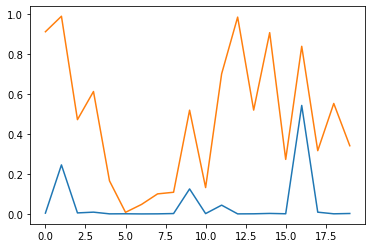

In [87]:
plot(mrestimates[0]/mrestimates[0].sum())
plot(beta)

  0%|          | 0/1000 [00:00<?, ?it/s]

Results when using Markov Reduction = 0.999:
The observer trust weights are 
[0.51616401 0.77172301 0.52923738 0.56479882 0.41876922 0.44423314
 0.37814169 0.42425152 0.4831811  0.7311354  0.48028925 0.65756633
 0.40638662 0.43717847 0.49294694 0.44601452 0.80887889 0.56198046
 0.43456195 0.49048713]
Estimators are delta_hat=0.842, b
The approximation b for f is 96.6% accurate.
The approximation delta_hat for delta=0.8590461529521575
has relative error -0.01984311657013712.


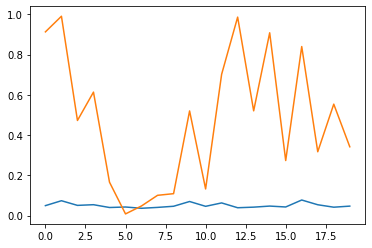

In [89]:
mrestimates = markov_reduce(data, reduction=0.999, agreement_thresh=0.5, printing=True)
plot(mrestimates[0]/mrestimates[0].sum())
plot(beta)

  0%|          | 0/1000 [00:00<?, ?it/s]

Results when using Markov Reduction = 0.8:
The observer trust weights are 
[2.29626139e-65 9.16444925e-28 5.22109392e-64 4.57269431e-59
 2.49780565e-85 1.75008561e-80 6.36014997e-95 3.63478561e-84
 3.02280687e-72 7.72103322e-35 2.07725706e-73 6.44219799e-45
 1.97896552e-88 9.62119740e-82 1.34239591e-70 4.27266995e-80
 3.38460656e-14 4.57269431e-59 2.01771134e-82 2.81520827e-71]
Estimators are delta_hat=0.82, b
The approximation b for f is 93.6% accurate.
The approximation delta_hat for delta=0.8590461529521575
has relative error -0.045452916374717885.


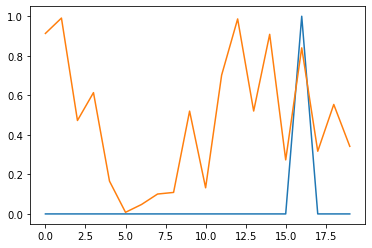

In [90]:
mrestimates = markov_reduce(data, reduction=0.8, agreement_thresh=0.5, printing=True)
plot(mrestimates[0]/mrestimates[0].sum())
plot(beta)

In [72]:
w = weights=ones(o.shape[1])
print(np.bincount(o[0],weights=w))
w[0]=10
print(np.bincount(o[0],weights=w))

[ 2.  7. 11.]
[ 2.  7. 20.]
